The list of imports:

In [10]:
import numpy as np
import librosa as lbr
import matplotlib.pyplot as plt
import soundfile as sf
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import random

In [11]:
tree = ET.parse('settings.xml')
root = tree.getroot()

window_size = int(root[3].find('window').text)                                  # size of deciphering windows
amplitude_threshold = 200                                                       # starting from that amplitude, the sound is counted as important
threshold = 50                                                                  # starting from this value, the signal is seemed to be mutated
search_range = 500                                                              # defining the maximum differences of two instruments positions

# Physical parameters of the audio recording
vertical_distance = float(root[0].find('vertical').text)                        # the distance between front and back microphones in meters
horizontal_distance = float(root[0].find('horizontal').text)                    # the distance between left and right microphones
sound_speed = float(root[2].find('speed').text)                                 # the speed of sound in the air (in m/s)
instruments_amount = int(root[1].find('number').text)                           # it is a hyperparameter, where should be pointed the number of instruments in the recording
audio_name = 'Input/'+ root[2].find('audio').get('name')

In [12]:
# Importing the quadraphonic audio file
#   rec, sr = lbr.load('Alto+Bass.wav', sr = 44100, mono = False)
rec, sr = sf.read(audio_name)

Generating borders for each of the notes

In [14]:
# The base frequency of the A0 note - 55 is a default value for the most of the modern audio recordings
basis = 55

notes = {}
for n in range(85):
    note_freq = basis * np.pow(2, ((2*n+1)/24))
    note = ''
    if n % 12 == 0: # This cases switch defines the upper border for each note
        note = 'A'
    elif n % 12 == 1: 
        note = 'Bb'
    elif n % 12 == 2: 
        note = 'B'
    elif n % 12 == 3: 
        note = 'C'
    elif n % 12 == 4: 
        note = 'C#'
    elif n % 12 == 5: 
        note = 'D'
    elif n % 12 == 6: 
        note = 'D#'
    elif n % 12 == 7: 
        note = 'E'
    elif n % 12 == 8: 
        note = 'F'
    elif n % 12 == 9: 
        note = 'F#'
    elif n % 12 == 10: 
        note = 'G'
    elif n % 12 == 11: 
        note = 'G#'

    note += str(int(np.floor((n + 9)/12)))
    notes[note] = note_freq

In [15]:
print(rec.shape) # Ensuring that the audio file is quadraphonic

# Assigning each recorded channel to the "Front-Back" and "Left-Right" microphones 
FL = rec[:,0]
FR = rec[:,1]
BL = rec[:,2]
BR = rec[:,3]

(1155129, 4)


In [16]:
print(np.max(np.abs(BR)))

0.3074694275856018


Visualization of the audio recording by frequencies 

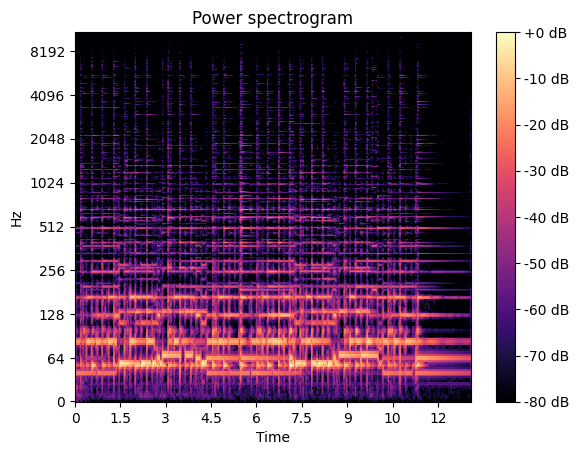

In [ ]:
# Displaying the role-holding frequencies of the recording
FL_shifted = np.append(np.zeros(230), FL)
FR_shifted = np.append(FR, np.zeros(230))
fury = lbr.stft(FL_shifted + (FR_shifted  * (-1)), n_fft = window_size)
fig, ax = plt.subplots()
img = lbr.display.specshow(lbr.amplitude_to_db(np.abs(fury), ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

Obtaining strong notes for each of the windows

In [117]:
def amplitudes_for_window_calculation(window, signal):
    start = window * window_size
    end = start + window_size
    current_window = signal[start:end]
        
    # Если окно меньше window_size, дополняем нулями
    if len(current_window) < window_size:
        current_window = np.pad(current_window, (0, window_size - len(current_window)), mode='constant')

    # Finding the amplitudes for every sound-shaping audiowanes in the current window
    transformed_sound = np.fft.rfft(current_window)
    magnitudes = np.abs(transformed_sound)

    return magnitudes

Here, the main notes of the audio file for all the windows are discovered

In [118]:
# The number of windows, calculated on the base of the length of the FL channel duration
windows_count = int(np.ceil(len(FL) / window_size)) 

# The list of windows with the recognized notes
window_notes = []

for window in range(windows_count):  # calculations are performed for each of the windows

    # Storage of the power for each of the notes
    notes_strength = np.zeros(85)

    # Here will be saved recognized notes for the current window
    valid_notes = []
    
    # Calculating the data inside the window
    magnitudes = amplitudes_for_window_calculation(window, FL)
    
    # Obtaining the data about frequencies that are found by Fourier transform
    freqs = np.fft.rfftfreq(window_size, d=1/sr)

    # Assigning each of the frequencies that were "heard" in the window to the musical notes
    for frequ in freqs:
        # Only frequencies in the range of notes A0-A7 are taken into account
        if frequ >= basis and frequ <= basis * 128:
            # Obtaining the list of possible notes
            for num, note in enumerate(notes):
                # Here, the power of the observed frequency (frequ) is assigned to the nearest musical note
                if frequ >= notes[note]:
                    continue
                else:
                    notes_strength[num] += magnitudes[np.argwhere(freqs == frequ)]
                    break

    # After that function, only the notes with the power more than (amplitude_threshold) are left
    for stren in notes_strength:
        if stren >= amplitude_threshold:
            valid_notes.append(list(notes)[np.abs(notes_strength - stren).argmin()])

    # The list of "interesting notes" in the current window is stored in the whole array
    window_notes.append(valid_notes)

C:\Users\User\AppData\Local\Temp\ipykernel_23492\1079132721.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  notes_strength[num] += magnitudes[np.argwhere(freqs == frequ)]


Calculating the changes in the power of the previously discovered notes

In [119]:
def notes_strength_calculation(channel_1, channel_2):
    power_results = {}  # here will be saved the results of the notes strengths for each of the shifts

    # Inverting the second channel for the instruments extraction
    channel_2 *= (-1)

    # Trying to shift the second channel relatively to the first one
    for shift in tqdm(range(search_range * (-1), search_range + 1)):

        # The amplitudes for each of the notes in the windows for the current shift
        windows_amplitudes = []

        # Shifting the second channel relatively to the first
        if shift < 0:   # the second channel is shifted to the left
            shifted_ch2 = np.append(channel_2, np.zeros(np.abs(shift)))
            shifted_ch1 = np.append(np.zeros(np.abs(shift)), channel_1)
        elif shift > 0: # shifted to the right
            shifted_ch1 = np.append(channel_1, np.zeros(shift))
            shifted_ch2 = np.append(np.zeros(shift), channel_2)
        else:           # remains on its current position
            shifted_ch1 = channel_1
            shifted_ch2 = channel_2

        # Obtaining the summing audio wave
        combined_signal = shifted_ch1 + shifted_ch2

        # Recalculating the number of windows for shifting
        n_windows = int(np.ceil(len(combined_signal) / window_size))

        # Разбиваем combined_signal на окна по 8192 сэмпла
        for window in range(n_windows):

            # Finding the frequencies in the resulting wave
            magnitudes = amplitudes_for_window_calculation(window, combined_signal)

            # Obtaining frequencies array
            freqs = np.fft.rfftfreq(window_size, d=1/sr)

            # Finding the amplitudes for each of the notes in the current window
            amplitudes_of_notes = []
        
            # Taking a look on all the notes that were in the current window in the original audio
            for note_name in window_notes[window]:

                # The max frequency, which is practically is related to the note (note_name)
                max_freq = notes[note_name]

                # The minimal frequency - it is also the maximal frequency of the previous note in the gamma
                min_freq = notes[list(notes)[list(notes).index(note_name) - 1]]
            
                # Defining all the frequencies that are related to the cuurent note and summing their powers
                indeces = np.argwhere((freqs > min_freq) & (freqs <= max_freq))
                summing_magnitudes = np.sum(magnitudes[np.min(indeces) : (np.max(indeces) + 1)])
            
                # Providing an information about the new power of the notes in the current window
                amplitudes_of_notes.append(summing_magnitudes)

            # Saving an information about the amplitudes occuring in this window
            windows_amplitudes.append(amplitudes_of_notes)

        # Saving the list of results of all the windows for the current shift
        power_results[shift] = windows_amplitudes
    
    return power_results

In [120]:
def the_most_possible_shifts(result_matrix):
    
    # The weighted amount of amplitudes that are less than threshold parameter
    min_amplitudes_per_shift = []

    # Evaluating based on the current shift
    for shift, windows in result_matrix.items():
        # The initial weight is equal to zero
        mins_count = 0

        for window in windows:

            # If the window is not empty, the search takes place over it
            if window:
                for elem in window:
                    if elem <= threshold:

                        # The evaluating formula leads to the strong mark for the small amplitude (elem)
                        mins_count += (threshold - elem) ** 4
                        # mins_count += 1 / elem

        # Saving an information about evaluation level for the current shift
        min_amplitudes_per_shift.append(mins_count)

    # For non-interesting elements skipping
    struck = 0

    # Finding the places of the smallest predicted amplitudes
    the_quietest = np.sort(min_amplitudes_per_shift)

    # Predicted shifts for the current microphone pair
    overall_shifts = []

    # Amount of shifts is strongly equal to number of instruments in the audio recording
    for inst in range(instruments_amount):

        # Searching for the optimum shift
        while True:

            # Choosing the variant with the most silent notes
            candidate = the_quietest[len(the_quietest) - (inst + struck) - 1]

            # Defining the shift value for this candidate 
            position = min_amplitudes_per_shift.index(candidate)

            # Detecting whether the neighbor values are less than this candidate (whether it is local maximum)
            if min_amplitudes_per_shift[position - 1] < candidate and min_amplitudes_per_shift[position + 1] < candidate:

                # Adding the currently observed shift to the predicted shifts
                overall_shifts.append(position - 500)
                break
            else:
                # Skipping this element
                struck += 1
                continue

    return overall_shifts

In [121]:
fl_fr_matrix = notes_strength_calculation(FL, FR)
fl_fr = np.array(the_most_possible_shifts(fl_fr_matrix))
print(fl_fr)

fl_bl_matrix = notes_strength_calculation(FL, BL)
fl_bl = np.array(the_most_possible_shifts(fl_bl_matrix))
print(fl_bl)

fr_bl_matrix = notes_strength_calculation(FR, BL)
fr_bl = np.array(the_most_possible_shifts(fr_bl_matrix))
print(fr_bl)

bl_br_matrix = notes_strength_calculation(BL, BR)
bl_br = np.array(the_most_possible_shifts(bl_br_matrix))
print(bl_br)


100%|██████████| 1001/1001 [00:33<00:00, 29.67it/s]


[235  66]


100%|██████████| 1001/1001 [00:32<00:00, 30.96it/s]


[-31  12]


100%|██████████| 1001/1001 [00:32<00:00, 30.80it/s]


[-266  -54]


100%|██████████| 1001/1001 [00:32<00:00, 30.71it/s]

[210  69]


In [122]:
fl_fr_real = fl_fr / sr * sound_speed
fl_bl_real = fl_bl / sr * sound_speed
fr_bl_real = fr_bl / sr * sound_speed

pairs = []

for i in fl_fr_real:
    for j in fl_bl_real:
        for o in fr_bl_real:
            if j - i == o:
                pair = [i, j]
                pairs.append(pair)

# sqrt(x^2 + (vertical_distance - y)^2) - sqrt((horizontal_distance - x)^2 + (vertical_distance - y)^2) = pairs[i][0] => FL_FR distance
# sqrt(x^2 + (vertical_distance - y)^2) - sqrt(x^2 + y^2) = pairs[i][1] => FL_BL distance

instruments_coordinates = []

for b in pairs:

    x_left = 0
    x_right = horizontal_distance
    y_upper = vertical_distance
    y_lower = 0

    if b[0] < 0:
        x_right = (horizontal_distance + b[0]) / 2
    else:
        x_left = (horizontal_distance + b[0]) / 2

    if b[1] < 0:
        y_lower = (vertical_distance - b[1]) / 2
    else:
        y_upper = (vertical_distance - b[1]) / 2


    x_axes = np.array([x_left, x_right])
    y_axes = np.array([y_lower, y_upper])
    while (x_axes[1] - x_axes[0]) > np.pow(0.1, 8) and (y_axes[1] - y_axes[0]) > np.pow(0.1, 8):
        for border in range(2):
            left_border = x_left
            right_border = x_right

            y_result = 10
            x = 0

            while np.abs(y_result) > np.pow(0.1, 6):

                x = (left_border + right_border) / 2

                y_result = np.sqrt(np.pow(x, 2) + np.pow(vertical_distance - y_axes[border], 2)) - np.sqrt(np.pow((horizontal_distance - x), 2) + np.pow(vertical_distance - y_axes[border], 2)) - b[0]

                if y_result < 0:
                    left_border = x
                else:
                    right_border = x

            # print(y_result, "(x): ", left_border, ", ", right_border)

            if (b[0] < 0 and border == 0) or (b[0] > 0 and border == 1):
                x_left = x
            else:
                x_right = x

        x_axes[0] = x_left
        x_axes[1] = x_right
        #print(x_axes)

        for border in range(2):
            upper_border = y_upper
            lower_border = y_lower

            x_result = 10
            y = 0
            # print(upper_border, lower_border)
            while np.abs(x_result) > np.pow(0.1, 6):

                y = (upper_border + lower_border) / 2

                x_result = np.sqrt(np.pow(x_axes[border], 2) + np.pow((vertical_distance - y), 2)) - np.sqrt(np.pow(x_axes[border], 2) + np.pow(y, 2)) - b[1]

                if x_result < 0:
                    upper_border = y
                else:
                    lower_border = y

                # print(x_result, " (y): ", upper_border, ", ", lower_border)

            if (b[1] < 0 and border == 0) or (b[1] > 0 and border == 1):
                y_lower = y
            else:
                y_upper = y

        y_axes[0] = y_lower 
        y_axes[1] = y_upper
        #print(y_axes)

    # print(x_left, x_right)
    # print(y_result)
    # print(y_lower, y_upper)
    # print(x_result)
    
    coordinates = [np.average(x_axes), np.average(y_axes)]
    print(coordinates)
    instruments_coordinates.append(coordinates)

    # time_fl = np.ceil(np.sqrt(np.pow(coordinates[0], 2) + np.pow((coordinates[1] - vertical_distance), 2)) / sound_speed * discretization_rate)
    # time_fr = np.ceil(np.sqrt(np.pow((coordinates[0] - horizontal_distance), 2) + np.pow((coordinates[1] - vertical_distance), 2)) / sound_speed * discretization_rate)

    # times = [time_fl, time_fr]
    # print(times)
    # exact_time.append(times)


[np.float64(3.503534373568529), np.float64(1.7999406809659195)]
[np.float64(2.7978717331964678), np.float64(1.4035025600172364)]


In [140]:
decoder_matrix = []
microphones = [[0, vertical_distance], [horizontal_distance, vertical_distance], [0, 0], [horizontal_distance, 0]]

for micro in microphones:
    decoded_insts = []
    for instrument in instruments_coordinates:
        time = int(np.ceil(np.sqrt(np.pow(instrument[0] - micro[0], 2) + np.pow((instrument[1] - micro[1]), 2)) / sound_speed * sr))
        decoded_insts.append(time)
    decoder_matrix.append(decoded_insts)

decoded_sound = [[] for _ in range(len(instruments_coordinates))]

for inst in range(len(decoder_matrix[2])):
    for i in range(5):
        flag = 0
        for BlBr in bl_br:
            if np.abs((decoder_matrix[2][inst] - BlBr) - decoder_matrix[3][inst]) == i:
                flag = decoder_matrix[2][inst] - BlBr
        if flag != 0:
            decoder_matrix[3][inst] = int(flag)
            break
        else: continue

print(decoder_matrix)

rec, sr = sf.read('Input/flute_trio_tenor_int32.wav', dtype = 'int32')

[[488, 425], [253, 359], [519, 413], [309, 344]]


In [142]:
rec, sr = sf.read('Input/flute_trio_tenor_int32.wav', dtype = 'int32')
soprano, sr = sf.read('Input/soprano_int32.wav', dtype = 'int32')
alto, sr = sf.read('Input/alto_int32.wav', dtype = 'int32')
#tenor, sr = sf.read('Input/tenor.wav', dtype = "int32")
bass, sr = sf.read('Input/bass_int32.wav', dtype = 'int32')

counter = 0
counter2 = 0
for i in range(1000):
    rand_micro = random.randint(0, 3)
    rand_place = random.randint(0, len(rec[:, rand_micro]) - 1)
    value = rec[rand_place, rand_micro]
    print(f"Value in the position [{rand_micro}:{rand_place}]: {value}")
    value_soprano = soprano[rand_place, rand_micro]
    value_alto = alto[rand_place, rand_micro]
    #value_tenor = tenor[rand_place, rand_micro]
    value_bass = bass[rand_place, rand_micro]
    print(f"Flutes in this position: {value_soprano}, {value_alto}, {value_bass}.")
    cum_sum1 = value_bass + value_alto + value_soprano
    cum_sum2 = value_soprano + value_bass + value_alto
    if cum_sum1 != cum_sum2:
        print("GG tak-to :)")
        print(f"First: {cum_sum1}, second: {cum_sum2}. Delta: {cum_sum1 - cum_sum2}")
        print(f"Types of values: {cum_sum1.dtype}, {cum_sum2.dtype}.")
        print(f"Types of instrumental recs: {value_soprano.dtype}, {value_alto.dtype}, {value_bass.dtype}.")
        print(f"Position: [{rand_micro + 1},{rand_place}]")
        counter2 += 1
    # print(f"Data type of alto: {value_alto.dtype}, data type of soprano: {value_soprano.dtype}")
    # cum_sum += value_bass + value_alto
    #print(f"Cumulative sum: {cum_sum1}")
    if value == cum_sum2:
        continue
    else:
        print(f"Fail: {cum_sum2 - value}")
        counter += 1
print(f"Failed results: {counter}, {counter2}")

Value in the position [3:918929]: 15360224
Flutes in this position: 0, 45301740, -29941516.
Value in the position [3:217227]: -14291391
Flutes in this position: 334449, 54298440, -68924280.
Value in the position [0:428147]: 172792864
Flutes in this position: 1281182, 95630920, 75880768.
Fail: 6
Value in the position [1:163756]: 87044272
Flutes in this position: -8867088, 36026216, 59885140.
Fail: -4
Value in the position [2:588389]: 62245928
Flutes in this position: -9455089, 17985002, 53716016.
Fail: 1
Value in the position [0:928491]: -14317384
Flutes in this position: 0, -56339304, 42021920.
Value in the position [0:383589]: -48820072
Flutes in this position: -105388448, -92325, 56660700.
Fail: -1
Value in the position [0:927810]: -86752464
Flutes in this position: 0, -41713548, -45038916.
Value in the position [1:603630]: 42426348
Flutes in this position: 43857152, -98184, -1332620.
Value in the position [3:751333]: 65801120
Flutes in this position: -14430448, -3899779, 84131344.
F

In [144]:
rec, sr = sf.read('Input/flute_trio_tenor.wav', dtype = 'float32')
soprano, sr = sf.read('Input/soprano.wav', dtype = 'float32')
alto, sr = sf.read('Input/alto.wav', dtype = 'float32')
#tenor, sr = sf.read('Input/tenor.wav', dtype = "int32")
bass, sr = sf.read('Input/bass.wav', dtype = 'float32')

counter = 0
counter2 = 0
for i in range(1000):
    rand_micro = random.randint(0, 3)
    rand_place = random.randint(0, len(rec[:, rand_micro]) - 1)
    value = rec[rand_place, rand_micro]
    print(f"Value in the position [{rand_micro}:{rand_place}]: {value}")
    value_soprano = soprano[rand_place, rand_micro]
    value_alto = alto[rand_place, rand_micro]
    #value_tenor = tenor[rand_place, rand_micro]
    value_bass = bass[rand_place, rand_micro]
    print(f"Flutes in this position: {value_soprano}, {value_alto}, {value_bass}.")
    cum_sum1 = value_bass + value_alto + value_soprano
    cum_sum2 = value_soprano + value_bass + value_alto
    if cum_sum1 != cum_sum2:
        print("GG tak-to :)")
        print(f"First: {cum_sum1}, second: {cum_sum2}. Delta: {cum_sum1 - cum_sum2}")
        print(f"Types of values: {cum_sum1.dtype}, {cum_sum2.dtype}.")
        print(f"Types of instrumental recs: {value_soprano}, {value_alto}, {value_bass}.")
        print(f"Position: [{rand_micro + 1},{rand_place}]")
        counter2 += 1
    # print(f"Data type of alto: {value_alto.dtype}, data type of soprano: {value_soprano.dtype}")
    # cum_sum += value_bass + value_alto
    #print(f"Cumulative sum: {cum_sum1}")
    if value == cum_sum2:
        continue
    else:
        print(f"Fail: {cum_sum2 - value}")
        counter += 1
print(f"Failed results: {counter}, {counter2}")

Value in the position [1:375200]: 0.030004557222127914
Flutes in this position: 0.04855838045477867, -0.01050353143364191, -0.008050292730331421.
Value in the position [0:217340]: 0.008966756984591484
Flutes in this position: -4.092075687367469e-05, -0.02744700387120247, 0.03645468130707741.
GG tak-to :)
First: 0.008966756984591484, second: 0.008966755121946335. Delta: 1.862645149230957e-09
Types of values: float32, float32.
Types of instrumental recs: -4.092075687367469e-05, -0.02744700387120247, 0.03645468130707741.
Position: [1,217340]
Fail: -1.862645149230957e-09
Value in the position [3:413061]: 0.06098293140530586
Flutes in this position: 0.0529891774058342, 0.03262577950954437, -0.024632025510072708.
Value in the position [3:138568]: 0.03949408978223801
Flutes in this position: 0.03484649211168289, -0.00016728272021282464, 0.004814880434423685.
Value in the position [0:762298]: -0.014876050874590874
Flutes in this position: 0.01681661047041416, -0.0002098487748298794, -0.0314828

In [141]:
bass_int, sr = sf.read('Input/bass_int32.wav', dtype = 'int32')
print(np.max(bass_int))
print(np.mean(bass_int))
rec, sr = sf.read('Input/alto+soprano_int32.wav', dtype = 'int32')

127951224
98.89068715270398


In [139]:
growth_begin = 0
growth_end = 0
while (growth_begin + growth_end + 100) < len(FL):
    work = growth_begin / len(FL) * 100
    percent_work = str(("%.2f" % work)) + '%'
    print(f"Audio extraction: {percent_work}", end = '\r')
    minimals = [] # The position of the first instrument occurance
    min_indexes = [] # Which instrument has occured firstly
    deltas = [] # For how long it is soloing
    for micros in decoder_matrix:
        minval = np.min(micros) # finding the first occurance for the current microphone
        minimals.append(minval) # adding it to the list of minimals
        micro_sort = np.sort(micros) 
        try:
            delta = micro_sort[1] - minval  # finding the difference between the first and the second instruments (the pure voice)
        except IndexError:
            print("Only one istrument in the rec")
            delta = len(FL) - minval    # all the rec is already one instrument
        deltas.append(delta)
        indek = micros.index(minval)
        min_indexes.append(indek)

    # print(minimals, min_indexes, deltas)

    growth_index = int(min_indexes[np.argmax(deltas)]) # Which instrument is retrieved
    growth_end = int(np.max(deltas)) # For how long it is retrieved
    growth_begin = int(minimals[np.argmax(deltas)]) # From which position we should start retrieving
    micro_index = int(np.argmax(deltas)) # From which of the microphones

    # print(growth_index, growth_begin, growth_end, micro_index)

    channel = rec[:, micro_index]

    working_wave = np.array(channel[(growth_begin - 1) : (growth_begin + growth_end - 1)])
    # print("Working wave: ", working_wave)
    # print("Content of the current microphone before: ", rec[micro_index][int(growth_begin - 1) : int(growth_begin + growth_end - 1)])
    # print(len(working_wave))
    decoded_sound[growth_index] = np.append(decoded_sound[growth_index], working_wave)
    # print(decoded_sound.shape)
    # print(len(decoded_sound[growth_index]))

    # Debugging
    #file = ""
    #if (micro_index == 0):
    #    file = "mic_1.txt"
    #elif (micro_index == 1):
    #    file = "mic_2.txt"
    #elif (micro_index == 2):
    #    file = "mic_3.txt"
    #elif (micro_index == 3):
    #    file = "mic_4.txt"

    #boundary = str(growth_begin) + " - " + str(growth_begin + growth_end)

    #with open(file, "a") as f:
    #    f.write(boundary)
    #    f.write("\n")
    #    f.write(np.array2string(working_wave, separator=" "))
    #    f.write("\n")
        
    working_wave *= -1 # For excluding from each of the instruments waves
    # print("Inverted: ", working_wave)
    # print("Content of the current microphone after: ", rec[micro_index][int(growth_begin - 1) : int(growth_begin + growth_end - 1)])
    # print(len(working_wave_fin))

    #if micro_index == 1:
    #    from_mic = 0
    #    summing = uku_guit_fl
    #elif micro_index == 3:
    #    from_mic = 1
    #    summing = flut_guit_fr
    #elif micro_index == 0:
    #    from_mic = 3
    #    summing = uku_flut_br

    #if micro_index == 1:
    #    from_mic = 2
    #    summing = uku_bl
    #elif micro_index == 2:
    #    from_mic = 1
    #    summing = flut_fr

    for mic in range(4):
        zero_shift = np.zeros(decoder_matrix[mic][growth_index] - 1) # Zeros before the instrument playing start; (-1) - not including
        forsumming = np.array(zero_shift, 'int32')
        forsumming = np.array(np.append(zero_shift, working_wave), dtype = 'int32')
        #    print(len(zero_shift))
        #    print(len(forsumming) - len(zero_shift))
        if len(forsumming) <= len(rec[:, mic]):
            zero_shift_right = np.zeros(len(rec[:, mic]) - len(forsumming))
            forsumming = np.array(np.append(forsumming, zero_shift_right), dtype = 'int32')
            #if mic == 0 and growth_index == 0:
                # print("Forsumming: ", forsumming[len(zero_shift) : len(rec[mic]) - len(zero_shift_right)])
                #print("MAXIMUM: ", np.max(np.abs(forsumming[len(zero_shift) : len(rec[mic]) - len(zero_shift_right)])), " FOR ", growth_index) 
            #print("Rec mic before: ", rec[mic][len(zero_shift) : len(rec[mic]) - len(zero_shift_right)])
            #print("Mic ", mic, " average: ", np.average(rec[mic][len(zero_shift) : len(rec[mic]) - len(zero_shift_right)]), "BEFORE.")
            rec[:, mic] += forsumming
            #print(forsumming.dtype)
            #if mic == from_mic:
            #    init = rec[(decoder_matrix[mic][growth_index] - 1) : (decoder_matrix[mic][growth_index] - 1 + growth_end), mic]
            #    plus = summing[(decoder_matrix[mic][growth_index] - 1) : (decoder_matrix[mic][growth_index] - 1 + growth_end)]
            #    minus = plus * (-1)
            #    res = init + minus
            #    if np.max(np.abs(res)) == 0:
            #        print('Success!')
            #        print(np.max(np.abs(init)))
            #    else:
            #        print('Fail!')
            #        print(init)
            #        print(res)
            #if np.max(rec[:, mic]) >= 1:
            #    print("FAIL!")
            #    print(rec[(decoder_matrix[mic][growth_index] - 1) : (decoder_matrix[mic][growth_index] - 1 + growth_end), mic])
            #if mic == micro_index:
            #    if np.sum(np.abs(rec[int(growth_begin - 1) : int(growth_begin + growth_end - 1), mic])) != 0:
            #        print("FAIL!")
            #    else:
            #        print("OK")
            #good_adding = "mic " + str(mic + 1) + ": " + str(len(zero_shift) + 1) + "-" + str(len(zero_shift) + len(working_wave))
            #with open(file, "a") as f:
            #    f.write(good_adding)
            #    f.write("\n")
            #print("Mic ", mic, " average: ", np.average(rec[mic][len(zero_shift) : len(rec[mic]) - len(zero_shift_right)]), "AFTER.")
            # print("Rec mic ", mic, " after: ", rec[mic][len(zero_shift) : len(rec[mic]) - len(zero_shift_right)])
            decoder_matrix[mic][growth_index] += growth_end

    # decoded_sound[growth_index].append(working_wave)

    # print(decoded_sound[2])
    # print(decoder_matrix)
    #with open(file, "a") as f:
    #    f.write("\n\n")

# print(decoded_sound[0])
# print(decoded_sound[1])
# print(decoded_sound[2])

KeyboardInterrupt: 

In [ ]:
# lbr.display.waveshow(np.asarray(decoded_sound[0]), sr = sr, max_points = int(sr / 16))
# lbr.display.waveshow(np.asarray(decoded_sound[1]), sr = sr, max_points = int(sr / 16))
# lbr.display.waveshow(np.asarray(decoded_sound[2]), sr = sr, max_points = int(sr / 16))

# sf.write('guitar.wav', decoded_sound[0], discretization_rate)
# sf.write('ukulele.wav', decoded_sound[0], sr)
# sf.write('flute.wav', decoded_sound[1], sr)

output_folder = 'Output'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
else:
    for file in os.listdir(output_folder):
        file_path = os.path.join(output_folder, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

for q in range(len(decoded_sound)):
    file_name = 'instrument_' + str(q + 1) + '.wav'
    destination = 'Output/' + file_name
    sf.write(destination, decoded_sound[q], sr)

In [ ]:
sf.write('test.wav', rec[:, 0], sr)

sf.write('check.wav', forsumming, sr)

In [ ]:
print(decoded_sound)
print(len(decoded_sound[0]))

[array([ 0.        ,  0.        ,  0.        , ..., -0.17822286,
       -0.27223068, -0.35635483]), array([ 0.        , -0.00046645, -0.00068995, ...,  0.17822286,
        0.27223068,  0.35635483])]
954530


In [ ]:
print(forsumming)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
# print(rec[3][int(5426 - 1) : int(5426 + 69 - 1)])
print(rec[:, 3].dtype)
print(forsumming.dtype)
print(working_wave.dtype)
print(np.max(np.abs(rec[0 : (len(rec[:, 0]) - 1000), 0])))
print(np.max(np.abs(rec[0 : (len(rec[:, 1]) - 1000), 1])))
print(np.max(np.abs(rec[0 : (len(rec[:, 2]) - 1000), 2])))
print(np.max(np.abs(rec[0 : (len(rec[:, 3]) - 1000), 3])))

float32
float64
float32
1.7610626
0.0
0.0
1.8518449


In [ ]:
print(rec[5, 3].dtype)

float32
